In [31]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import time
from keras.utils import np_utils
import tensorflow as tf
from keras.models import Sequential 
from keras.layers import Dense
from keras.layers import Input
from keras.layers import SimpleRNN
from sklearn.metrics import matthews_corrcoef 
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error


In [71]:
# 1) Data Preparation
names = ["date", "TLISE", "USDISE", "SP", "DAX", "FTSE", "NIKKEI", "BOVESPA", "EU", "EM"]
types = {
    "date": str,
    "TLISE": np.float64,
    "USDISE": np.float64,
    "SP": np.float64,
    "DAX": np.float64,
    "FTSE": np.float64,
    "NIKKEI": np.float64,
    "BOVESPA": np.float64,
    "EU": np.float64,
    "EM": np.float64    
}

# Load data
data = pd.read_excel("data_akbilgic.xlsx", header=None, names=names, skiprows=2, dtype=types)

In [72]:
# Drop date and TLISE, we will work with USDISE.
data.drop("date", inplace=True, axis=1)
data.drop("TLISE", inplace=True, axis=1)

In [73]:
# Drop NAs and pick the first 530 records.
data.dropna(inplace=True)
data = data.iloc[:529]
data.head(5)

,USDISE,SP,DAX,FTSE,NIKKEI,BOVESPA,EU,EM
0,0.038376,-0.004679,0.002193,0.003894,0.000000,0.031190,0.012698,0.028524
1,0.031813,0.007787,0.008455,0.012866,0.004162,0.018920,0.011341,0.008773
2,-0.026353,-0.030469,-0.017833,-0.028735,0.017293,-0.035899,-0.017073,-0.020015
3,-0.084716,0.003391,-0.011726,-0.000466,-0.040061,0.028283,-0.005561,-0.019424
4,0.009658,-0.021533,-0.019873,-0.012710,-0.004474,-0.009764,-0.010989,-0.007802


In [74]:
# Set index
data_index = data.reset_index()
data_index.head(5)

,index,USDISE,SP,DAX,FTSE,NIKKEI,BOVESPA,EU,EM
0,0,0.038376,-0.004679,0.002193,0.003894,0.000000,0.031190,0.012698,0.028524
1,1,0.031813,0.007787,0.008455,0.012866,0.004162,0.018920,0.011341,0.008773
2,2,-0.026353,-0.030469,-0.017833,-0.028735,0.017293,-0.035899,-0.017073,-0.020015
3,3,-0.084716,0.003391,-0.011726,-0.000466,-0.040061,0.028283,-0.005561,-0.019424
4,4,0.009658,-0.021533,-0.019873,-0.012710,-0.004474,-0.009764,-0.010989,-0.007802


In [75]:
def set_size(w, h, ax=None):
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

def plot_attributes_hist(data):
    fig, ax = plt.subplots(4,2)
    set_size(10,10)
    # Exclude class column
    for i in range(2, len(data.columns)):
        x = data.iloc[:,0]
        usd = data.iloc[:,1]
        y = data.iloc[:, i]
        ax[(i - 2) // 2, (i - 2) % 2].plot(x, usd, "c", label="USDISE")
        ax[(i - 2) // 2, (i - 2) % 2].plot(x, y, "r", label=data.columns[i])
        ax[(i - 2) // 2, (i - 2) % 2].set_xlabel("time")
        ax[(i - 2) // 2, (i - 2) % 2].legend()

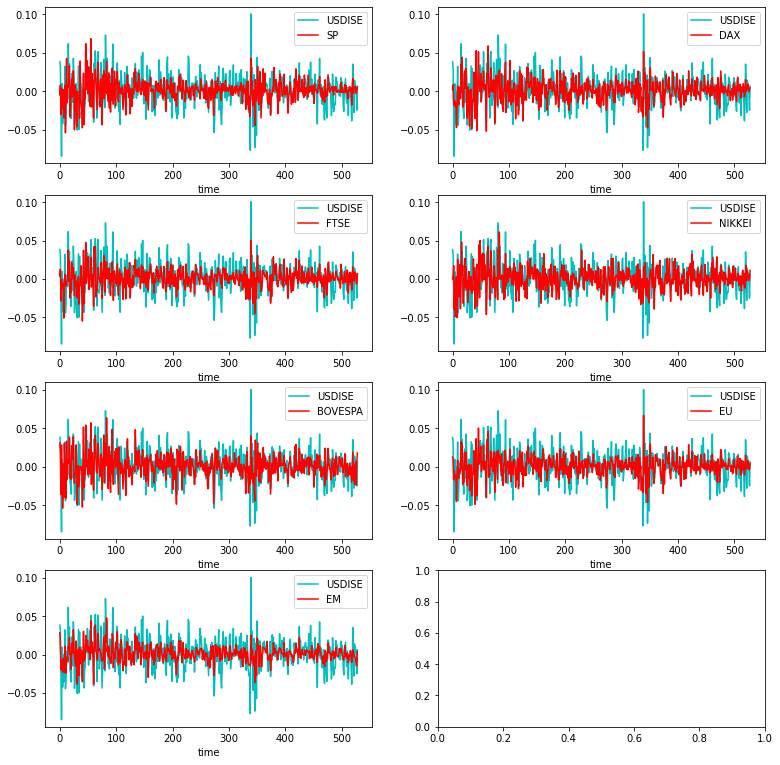

In [76]:
# Plot each attribute with the USDISE signal.
plot_attributes_hist(data_index)

In [77]:
# Data Standardization.
# Scaler only for USDISE.
usd_scaler = StandardScaler()
usdX = usd_scaler.fit_transform(np.reshape(data["USDISE"].values , (data.shape[0], 1)))
# Scaler for the other attributes.
scaler = StandardScaler()
dataX = scaler.fit_transform(np.array(data.iloc[:,1:]))

# To DataFrame
standardized_data = data.copy()
standardized_data.iloc[:,0] = usdX[:]
standardized_data.iloc[:,1:] = dataX[:,:]
standardized_data.head(5)

,USDISE,SP,DAX,FTSE,NIKKEI,BOVESPA,EU,EM
0,1.736028,-0.378457,0.099118,0.264087,-0.021632,1.916382,0.935166,2.622395
1,1.426363,0.503267,0.527318,0.969910,0.257529,1.139329,0.831114,0.745067
2,-1.317912,-2.202572,-1.270325,-2.303040,1.138142,-2.332096,-1.346950,-1.991118
3,-4.071492,0.192382,-0.852733,-0.078971,-2.708397,1.732288,-0.464498,-1.934886
4,0.381101,-1.570534,-1.409802,-1.042262,-0.321653,-0.677085,-0.880562,-0.830304


In [78]:
# Function to transform the initial data into timeseries data.
def timeseries_to_supervised(df, n_in, n_out):
  agg = pd.DataFrame()

  for i in range(n_in, 0, -1):
    df_shifted = df.shift(i).copy()
    df_shifted.rename(columns=lambda x: ('%s(t-%d)' % (x, i)), inplace=True)
    agg = pd.concat([agg, df_shifted], axis=1)

  for i in range(0, n_out):
    df_shifted = df.shift(-i).copy()
    if i == 0:
      df_shifted.rename(columns=lambda x: ('%s(t)' % (x)), inplace=True)
    else:
      df_shifted.rename(columns=lambda x: ('%s(t+%d)' % (x, i)), inplace=True)
    agg = pd.concat([agg, df_shifted], axis=1)
    
  agg.dropna(inplace=True)
  return agg

In [79]:
# MLP Implementation

n_in = 22
n_out = 1
ts = timeseries_to_supervised(standardized_data, n_in, n_out) 
print(ts.head(5))

USDISE(t-22)  SP(t-22)  DAX(t-22)  FTSE(t-22)  NIKKEI(t-22)  \
22      1.736028 -0.378457   0.099118    0.264087     -0.021632   
23      1.426363  0.503267   0.527318    0.969910      0.257529   
24     -1.317912 -2.202572  -1.270325   -2.303040      1.138142   
25     -4.071492  0.192382  -0.852733   -0.078971     -2.708397   
26      0.381101 -1.570534  -1.409802   -1.042262     -0.321653   

    BOVESPA(t-22)  EU(t-22)  EM(t-22)  USDISE(t-21)  SP(t-21)  ...   EU(t-1)  \
22       1.916382  0.935166  2.622395      1.426363  0.503267  ...  1.331036   
23       1.139329  0.831114  0.745067     -1.317912 -2.202572  ...  1.400616   
24      -2.332096 -1.346950 -1.991118     -4.071492  0.192382  ... -0.355503   
25       1.732288 -0.464498 -1.934886      0.381101 -1.570534  ...  1.427960   
26      -0.677085 -0.880562 -0.830304     -2.073183 -1.661734  ...  0.393140   

     EM(t-1)  USDISE(t)     SP(t)    DAX(t)   FTSE(t)  NIKKEI(t)  BOVESPA(t)  \
22  1.120122   1.021463 -0.579214  1.766

In [80]:
# Exlude all (t) values from x
X = ts.loc[:, list(map(lambda x: '(t)' not in x, ts.columns))].values
y = ts['USDISE(t)'].values
print(X.shape, y.shape)

(507, 176) (507,)


In [81]:
# Split data into train and test
len_data = X.shape[0]
train_size = int(len_data * .7)

xtr, ytr = X[:train_size, :], y[:train_size]
xte, yte = X[train_size:, :], y[train_size:] 
print(xtr.shape, ytr.shape) 
print(xte.shape, yte.shape)

(354, 176) (354,)
(153, 176) (153,)


In [82]:
# Building a model with SimpleRNN 
batch_size = 1
model = Sequential()

model.add(Dense(180, input_dim=xtr.shape[1], activation="tanh")) 
model.add(Dense(75, activation="tanh")) 
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy']) 
model.summary()


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 180)               31860     
_________________________________________________________________
dense_7 (Dense)              (None, 75)                13575     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 76        
Total params: 45,511
Trainable params: 45,511
Non-trainable params: 0
_________________________________________________________________


In [83]:

history = model.fit(xtr,ytr, epochs=200, batch_size=batch_size, verbose=0)

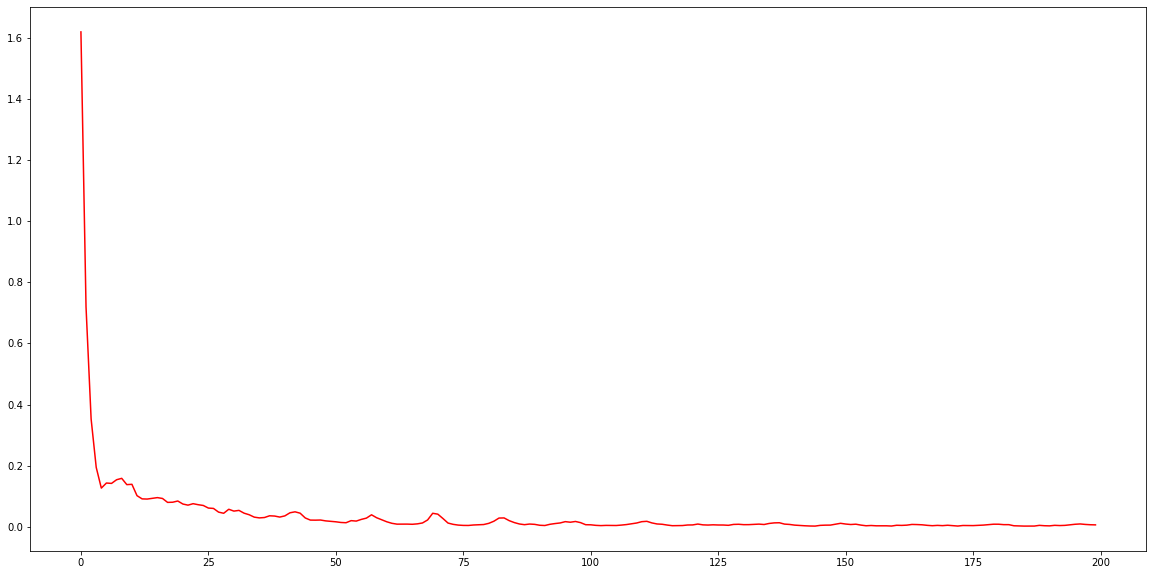

In [84]:

plt.figure(figsize=(20,10)) 
plt.subplot(1, 1, 1) 
plt.plot(history.history['loss'], c='r') 

plt.show()

In [85]:
# Predicting and plotting the result
trainPredict = model.predict(xtr, batch_size=batch_size) 
testPredict = model.predict(xte, batch_size=batch_size)

# invert predictions
ytr2d = np.reshape(ytr, (ytr.shape[0], 1)) 
yte2d = np.reshape(yte, (yte.shape[0], 1))

trainPredict = usd_scaler.inverse_transform(trainPredict)
trainY = usd_scaler.inverse_transform(ytr2d) 
testPredict = usd_scaler.inverse_transform(testPredict)
testY = usd_scaler.inverse_transform(yte2d) 
# calculate error
print("Train MSE: ", mean_squared_error(trainY, trainPredict)) 
print("Test MSE: ", mean_squared_error(testY, testPredict), '\n') 

print("Train R2: ", r2_score(trainY, trainPredict)) 
print("Test R2: ", r2_score(testY, testPredict),'\n') 


Train MSE:  2.4936682145942614e-06
Test MSE:  0.0004624242236586003 

Train R2:  0.9949560853894148
Test R2:  -0.9533922476785912 



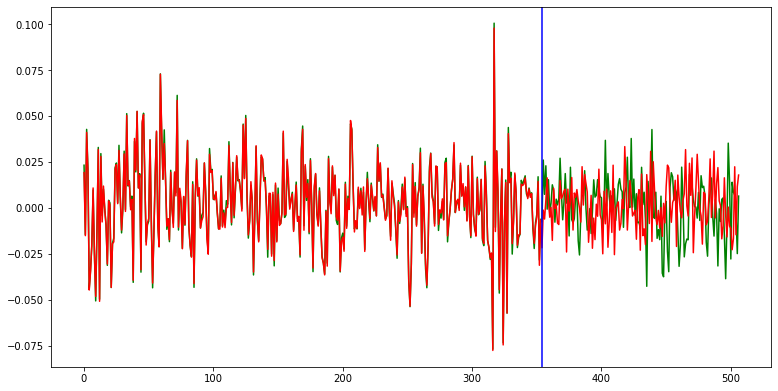

In [86]:
# Finally, we check the result in a plot. A vertical line in a plot identifies a splitting point between the training and the test part. 
original = np.concatenate((trainY,testY),axis=0) 
predicted = np.concatenate((trainPredict,testPredict),axis=0) 
index = range(0, original.shape[0]) 
plt.plot(index,original, 'g') 
plt.plot(index,predicted, 'r') 
plt.axvline(data.index[train_size], c="b")
set_size(10,5)
plt.show()

In [87]:
train_var = np.var(trainY)
test_var = np.var(testY)
print(f"train variance: {train_var}")
print(f"test variance: {test_var}")
print(f"train variance / test variance: {train_var/test_var}")

train variance: 0.0004943914413937571
test variance: 0.0002367288107179419
train variance / test variance: 2.0884295405125637


In [48]:
# RNN Implementation

n_in = 1
n_out = 1
ts = timeseries_to_supervised(standardized_data, n_in, n_out) 
print(ts.head(5))

USDISE(t-1)   SP(t-1)  DAX(t-1)  FTSE(t-1)  NIKKEI(t-1)  BOVESPA(t-1)  \
1     1.736028 -0.378457  0.099118   0.264087    -0.021632      1.916382   
2     1.426363  0.503267  0.527318   0.969910     0.257529      1.139329   
3    -1.317912 -2.202572 -1.270325  -2.303040     1.138142     -2.332096   
4    -4.071492  0.192382 -0.852733  -0.078971    -2.708397      1.732288   
5     0.381101 -1.570534 -1.409802  -1.042262    -0.321653     -0.677085   

    EU(t-1)   EM(t-1)  USDISE(t)     SP(t)    DAX(t)   FTSE(t)  NIKKEI(t)  \
1  0.935166  2.622395   1.426363  0.503267  0.527318  0.969910   0.257529   
2  0.831114  0.745067  -1.317912 -2.202572 -1.270325 -2.303040   1.138142   
3 -1.346950 -1.991118  -4.071492  0.192382 -0.852733 -0.078971  -2.708397   
4 -0.464498 -1.934886   0.381101 -1.570534 -1.409802 -1.042262  -0.321653   
5 -0.880562 -0.830304  -2.073183 -1.661734 -0.975783 -0.437699  -3.310467   

   BOVESPA(t)     EU(t)     EM(t)  
1    1.139329  0.831114  0.745067  
2   -2.3320

In [49]:
# Exlude all (t) values from x
X = ts.loc[:, list(map(lambda x: '(t)' not in x, ts.columns))].values
y = ts['USDISE(t)'].values
print(X.shape, y.shape)

(528, 8) (528,)


In [50]:
# Split data into train and test
len_data = X.shape[0]
train_size = int(len_data * .5)
test_size = len_data - train_size

xtr, ytr = X[:train_size, :], y[:train_size]
xte, yte = X[train_size:, :], y[train_size:] 
print(xtr.shape, ytr.shape) 
print(xte.shape, yte.shape)

(264, 8) (264,)
(264, 8) (264,)


In [60]:
steps = 3
train_samples = int(train_size/steps)
test_samples = int(test_size/steps)
print(f"train_samples: {train_samples}")
print(f"test_samples: {test_samples}")

features_in = 8
features_out = 1
xtr = np.reshape(xtr, (train_samples, steps, features_in))
ytr = np.reshape(ytr, (train_samples, steps, features_out))
print(xtr.shape, ytr.shape)
xte = np.reshape(xte, (test_samples, steps, features_in))
yte = np.reshape(yte, (test_samples, steps, features_out))
print(xte.shape, yte.shape)

train_samples: 88
test_samples: 88
(88, 3, 8) (88, 3, 1)
(88, 3, 8) (88, 3, 1)


In [61]:
# Building a model with SimpleRNN
batch_size = 1 
model = Sequential()

model.add(SimpleRNN(units=150, batch_input_shape=(batch_size, xtr.shape[1], xtr.shape[2]), activation="relu", return_sequences=True))
model.add(Dense(120, activation="relu")) 
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

model.summary()


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (1, 3, 150)               23850     
_________________________________________________________________
dense_4 (Dense)              (1, 3, 120)               18120     
_________________________________________________________________
dense_5 (Dense)              (1, 3, 1)                 121       
Total params: 42,091
Trainable params: 42,091
Non-trainable params: 0
_________________________________________________________________


In [62]:

history = model.fit(xtr,ytr, epochs=200, batch_size=batch_size, verbose=0)

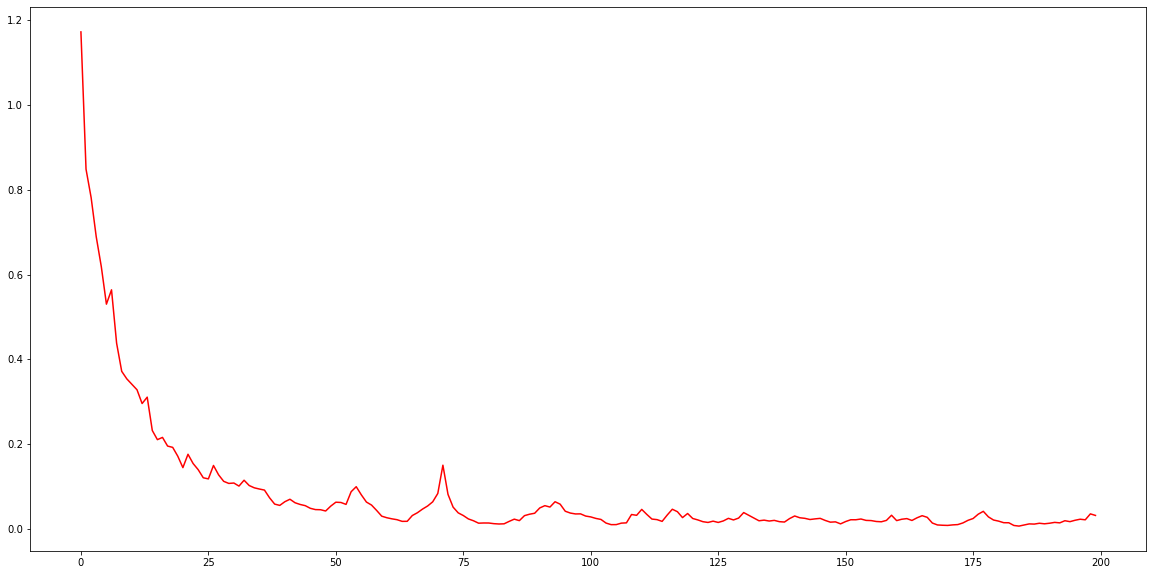

In [63]:

plt.figure(figsize=(20,10)) 
plt.subplot(1, 1, 1) 
plt.plot(history.history['loss'], c='r') 

plt.show()

In [64]:
# Predicting and plotting the result
trainPredict = model.predict(xtr, batch_size=batch_size)
testPredict = model.predict(xte, batch_size=batch_size)

# invert predictions
trainPredict = np.reshape(trainPredict, (train_samples*steps, features_out))
ytr2d = np.reshape(ytr, (train_samples*steps, features_out))
testPredict = np.reshape(testPredict, (test_samples*steps, features_out))
yte2d = np.reshape(yte, (test_samples*steps, features_out))

trainPredict = usd_scaler.inverse_transform(trainPredict)
trainY = usd_scaler.inverse_transform(ytr2d)
testPredict = usd_scaler.inverse_transform(testPredict)
testY = usd_scaler.inverse_transform(yte2d)

# calculate error
print("Train MSE: ", mean_squared_error(trainY, trainPredict)) 
print("Test MSE: ", mean_squared_error(testY, testPredict), '\n') 

print("Train R2: ", r2_score(trainY, trainPredict)) 
print("Test R2: ", r2_score(testY, testPredict),'\n') 



Train MSE:  1.1264440492302784e-05
Test MSE:  0.00046315897488658257 

Train R2:  0.9783830053897778
Test R2:  -0.2466260200156205 



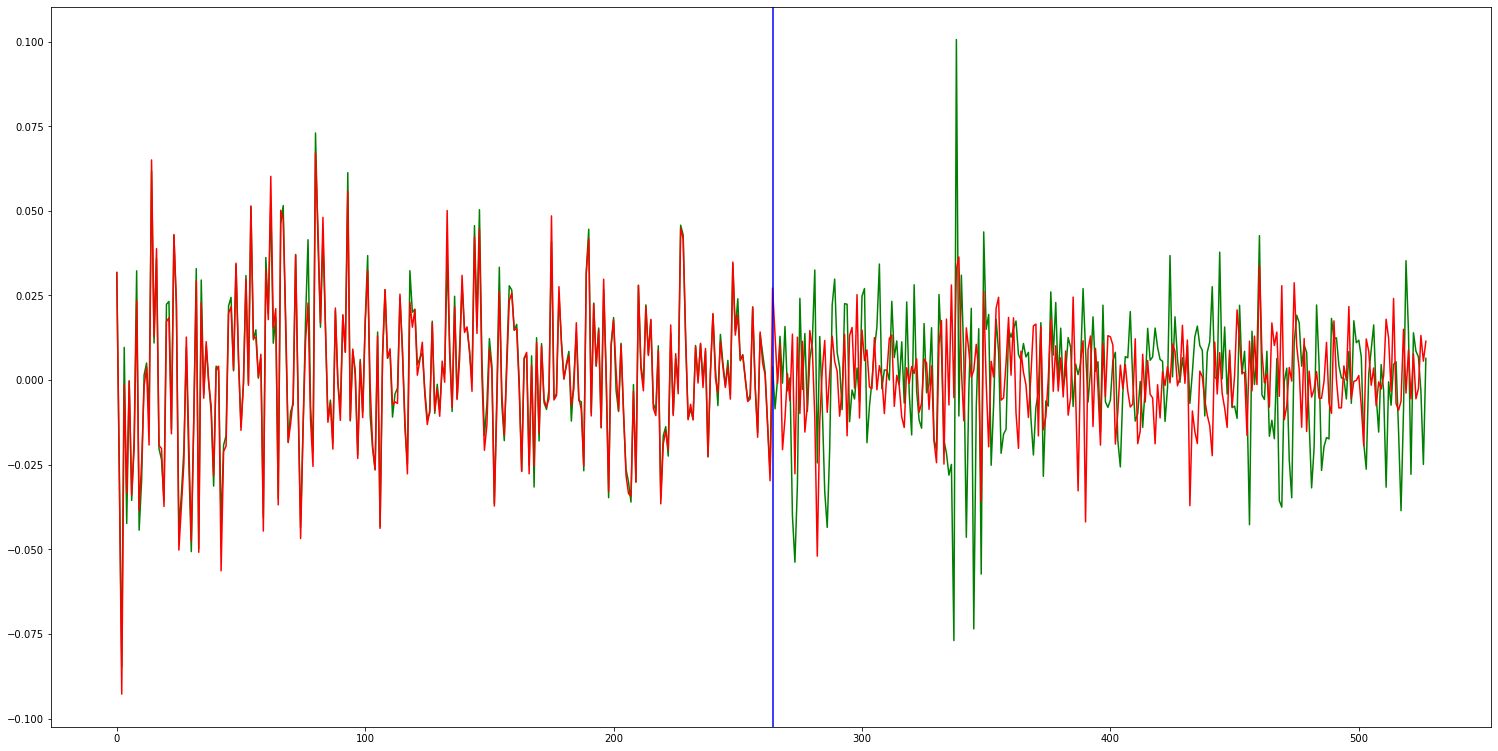

In [65]:
# Finally, we check the result in a plot. A vertical line in a plot identifies a splitting point between the training and the test part. 
original = np.concatenate((trainY,testY),axis=0) 
predicted = np.concatenate((trainPredict,testPredict),axis=0) 
index = range(0, original.shape[0]) 
plt.plot(index,original, 'g') 
plt.plot(index,predicted, 'r') 
plt.axvline(data.index[train_size], c="b")
set_size(20,10)
plt.show()

In [66]:
train_var = np.var(trainY)
test_var = np.var(testY)
print(f"train variance: {train_var}")
print(f"test variance: {test_var}")
print(f"train variance / test variance: {train_var/test_var}")

train variance: 0.0005210918860559889
test variance: 0.000371530007757081
train variance / test variance: 1.4025566580794102


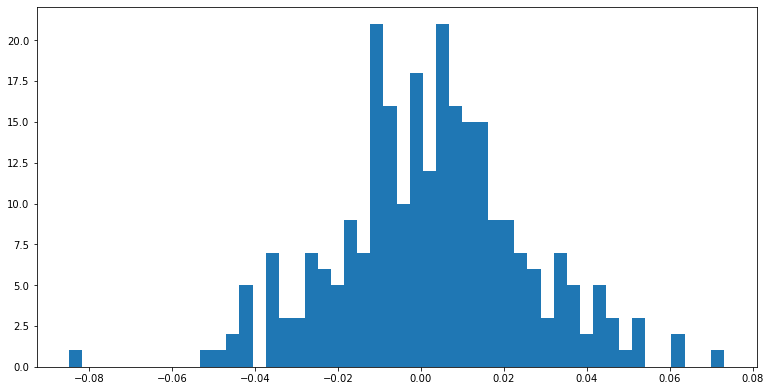

In [67]:
plt.hist(trainY, bins=50)
set_size(10,5)
plt.show()

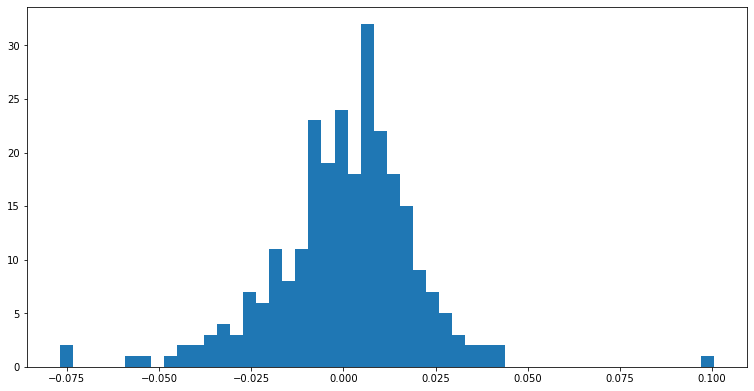

In [68]:
plt.hist(testY, bins=50)
set_size(10,5)
plt.show()